In [1]:
%matplotlib inline

# Зайцев Н. ПИ20-1В



---
Перевод [статьи](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) руководства PyTorch

Наборы и загрузчики данных
===================




Код для обработки образцов данных может быть запутанным и сложным в обслуживании; в идеале мы хотим, чтобы наш код набора
данных был отделен от кода обучения модели для лучшей читаемости и модульности.
PyTorch предоставляет два примитива данных: `torch.utils.data.DataLoader` и `torch.utils.data.Dataset`, которые позволяют вам использовать предварительно загруженные наборы данных, а также ваши собственные данные.
`Dataset` хранит образцы и соответствующие им метки, а `DataLoader` обертывает итерацию вокруг `Dataset`, чтобы обеспечить легкий доступ к образцам.

Библиотеки доменов PyTorch предоставляют ряд предварительно загруженных наборов данных (таких как FashionMNIST), которые
относятся к подклассу `torch.utils.data.Dataset` и реализуют функции, специфичные для конкретных данных.
Их можно использовать для создания прототипа и тестирования вашей модели. Вы можете найти их
здесь: [Наборы данных изображений](https://pytorch.org/vision/stable/datasets.html), [Текстовые наборы данных](https://pytorch.org/text/stable/datasets.html) и [Наборы данных аудио](https://pytorch.org/audio/stable/datasets.html)



Загрузка данных
-------------------
Вот пример того, как загрузить [Fashion-MNIST](https://research.zalando.com/project/fashion_mnist/fashion_mnist/) набор данных из TorchVision.
Fashion-MNIST -- это набор данных изображений статей Zalando, состоящий из 60 000 обучающих примеров и 10 000 тестовых примеров.
Каждый пример содержит изображение в оттенках серого 28×28 и соответствующую метку из одного из 10 классов.

Мы загружаем набор данных [Fashion MNIST](https://pytorch.org/vision/stable/datasets.html#fashion-mnist) со следующими параметрами:
- `root` - это путь, по которому хранятся данные обучающие/тестовые,
- `train` указывает набор данных для обучения или тестирования,
- `download=True` загружает данные из Интернета, если они недоступны в `root`,
- `transform` и `target_transform` определяют преобразования объектов и меток.


In [2]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

Перебор и визуализация набора данных
-----------------
Мы можем индексировать `Datasets` вручную, как список: `training_data[индекс]`.
Мы используем `matplotlib` для визуализации некоторых образцов в наших обучающих данных.

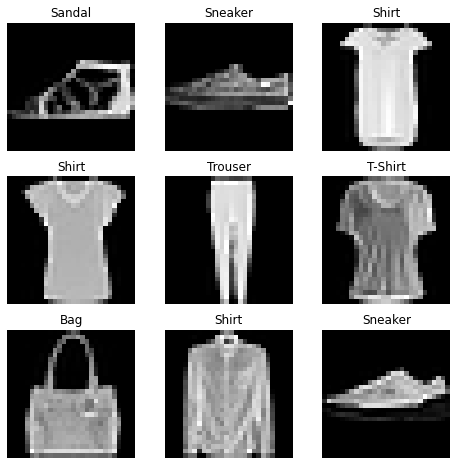

In [3]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

--------------




## Задание 1

Загрузите данные MNIST отобразите произвольные 9 изображений рукописных цифр.

In [4]:
train_dataset = datasets.MNIST('data', train=True, transform=ToTensor(), download=True)
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=9, shuffle=True)

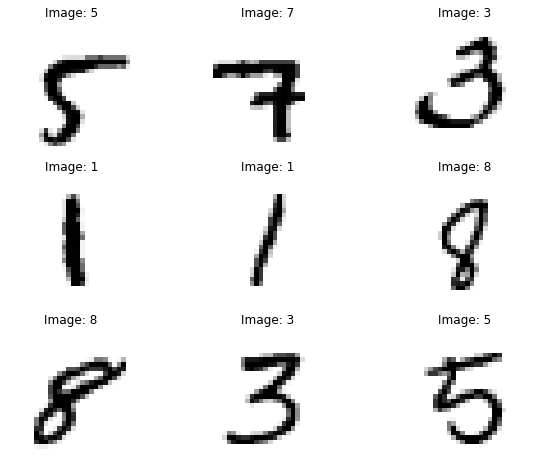

In [6]:
data = iter(train_dataloader)
imgs, labels = next(data)

plt.figure(figsize=(10,8))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(imgs[i][0], cmap='gray_r')
    plt.title(f"Image: {labels[i].item()}")
    plt.axis('off')
plt.show()

Создание пользовательского набора данных для ваших файлов
---------------------------------------------------
Пользовательский класс набора данных должен реализовывать три функции: `__init__`, `__len__` и `__getitem__`.
Взгляните на эту реализацию; изображения FashionMNIST хранятся
в каталоге `img_dir`, а их метки хранятся отдельно в CSV-файле `annotations_file`.

В следующих разделах мы разберем, что происходит в каждой из этих функций.


In [7]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

\_\_init\_\_
-----------
Функция \_\_init\_\_ запускается один раз при создании экземпляра объекта Dataset. Мы инициализируем каталог, содержащий изображения, файл аннотаций и оба преобразования (более подробно описано в следующем разделе).

CSV-файл меток выглядит следующим образом:

    tshirt1.jpg, 0
    tshirt2.jpg, 0
    ......
    ankleboot999.jpg, 9

In [8]:
def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
    self.img_labels = pd.read_csv(annotations_file)
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform

\_\_len\_\_
----------
Функция \_\_len\_\_ возвращает количество выборок в нашем наборе данных.

Пример:


In [9]:
def __len__(self):
    return len(self.img_labels)

\_\_getitem\_\_
-------
Функция \_\_getitem\_\_ загружает и возвращает образец из набора данных с заданным индексом `idx`.
На основе индекса он определяет местоположение изображения на диске, преобразует его в тензор с помощью `read_image`, извлекает
соответствующую метку из данных csv в `self.img_labels`, вызывает функции преобразования для них (если применимо) и возвращает тензорное изображение и соответствующую метку в кортеже.

In [10]:
def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
    image = read_image(img_path)
    label = self.img_labels.iloc[idx, 1]
    if self.transform:
        image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)
    return image, label

--------------




## Задание 2
Создайте класс набора данных для загрузки данных с диска. Создайте набор данных на основе файлов в папке cat_dog_images. Набор данных содается для классификации изображений для меток 1 - dog, 0 - cat. Используйте имя файла для определения метки.

In [13]:
import os
from PIL import Image
import torch.utils.data as data

class CatDog(data.Dataset):
    def __init__(self, files_dir, transform=None, target_trans=None):
        self.files_dir = files_dir
        self.transform = transform
        self.target_trans = target_trans
        self.list_of_files = os.listdir(files_dir)

    def __len__(self):
        return len(self.list_of_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.files_dir, self.list_of_files[idx])
        img = Image.open(img_path).convert('RGB')
        label = 1 if 'dog' in self.list_of_files[idx] else 0
        if self.transform:
            img = self.transform(img)
        if self.target_trans:
            label = self.target_trans(label)
        return img, label


In [14]:
from torchvision import transforms

transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
dataset = CatDog('cat_dog_images', transform=transform)

dataloader = data.DataLoader(dataset, batch_size=2, shuffle=True)

for imgs, labels in dataloader:
    print(imgs.shape, labels)

torch.Size([2, 3, 224, 224]) tensor([0, 1])
torch.Size([2, 3, 224, 224]) tensor([1, 0])
torch.Size([2, 3, 224, 224]) tensor([0, 1])


Подготовка ваших данных для обучения с помощью загрузчиков данных
-------------------------------------------------
`Dataset` извлекает объекты наборов данных и помечает по одному образцу за раз. При обучении модели мы обычно хотим
передавать образцы "мини-пакетами", переставлять данные в каждую эпоху, чтобы уменьшить перенастройку модели, и использовать `многопроцессорную обработку` Python для ускорения загрузки данных.

`DataLoader` - это итератор, который абстрагирует эту сложность для нас в простом API.


In [15]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Выполните итерацию через загрузчик данных
--------------------------

Мы загрузили этот набор данных в `DataLoader` и можем выполнять итерацию по набору данных по мере необходимости.
Каждая приведенная ниже итерация возвращает пакет `train_features` и `train_labels` (содержащий функции и метки `batch_size=64` соответственно).
Поскольку мы указали `shuffle=True`, после того, как мы переберем все пакеты, данные будут перемешаны (для более точного контроля над порядком загрузки данных взгляните на [`Samplers`](https://pytorch.org/docs/stable/data.html#data-loading-order-and-sampler).



Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


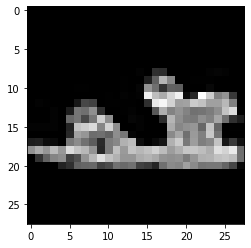

Label: 5


In [16]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

## Задание 3
Создайте загрузчик данных из набора задания 2, перемешайте данные и разбейте на пакеты размером по 2 файла. Визуализируйте данные первого пакета.

In [18]:
from torchvision import transforms
from torchvision.utils import make_grid

transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
dataset = CatDog('cat_dog_images', transform=transform)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True)

for images, labels in dataloader:
    print(images.shape, labels)

torch.Size([2, 3, 224, 224]) tensor([0, 0])
torch.Size([2, 3, 224, 224]) tensor([1, 1])
torch.Size([2, 3, 224, 224]) tensor([0, 1])


index:  0
img shape:  torch.Size([2, 3, 224, 224])
labels:  tensor([0, 1])


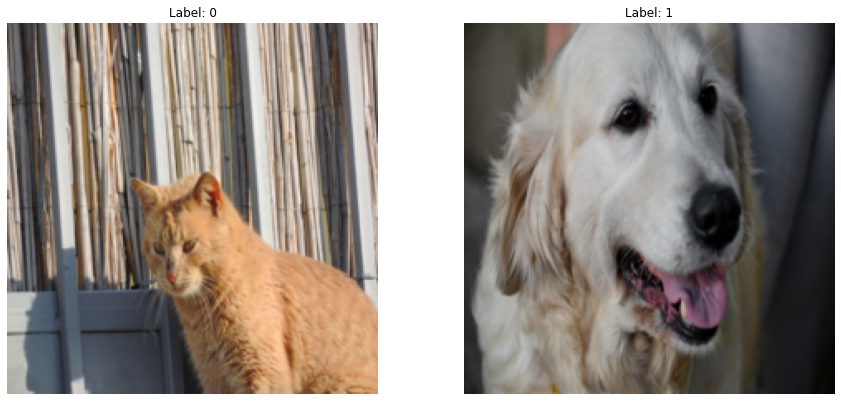

In [19]:
for ind, (images, labels) in enumerate(dataloader):
    print("index: ", ind)
    print("img shape: ", images.shape)
    print("labels: ", labels)
    plt.figure(figsize=(15, 15))
    for i in range(2):
        plt.subplot(2,2,i+1)
        plt.imshow(make_grid(images[i], nrow=1).permute(1, 2, 0))
        plt.title(f"Label: {labels[i].item()}")
        plt.axis('off')
    plt.show()
    break

 Преобразователи
 ----


Данные не всегда поступают в окончательной обработанной форме, необходимой для
обучения алгоритмам машинного обучения. Мы используем **преобразователи** для выполнения некоторых
манипуляций с данными и делаем их пригодными для обучения.

Все наборы данных TorchVision имеют два параметра -`transform` для изменения объектов и `target_transform` для изменения меток - которые принимают вызываемые объекты, содержащие логику преобразования.
Модуль[`torchvision.transforms`](https://pytorch.org/vision/stable/transforms.html) предлагает несколько часто используемых преобразований.

Данные FashionMNIST представлены в формате изображений PIL, а метки - целые числа.
Для обучения нам нужны функции в виде нормализованных тензоров, а метки - в виде однократно закодированных тензоров.
Чтобы осуществить эти преобразования, мы используем `ToTensor` и `Lambda`.



In [20]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

Функция ToTensor()
----
[`ToTensor`](https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.ToTensor) превращает PIL изображение или NumPy ndarray в FloatTensor и маштабирует его интенсивность пикселей в диапазон  [0., 1.]

Лямбда-преобразователь
-------------------------------
Лямбда-преобразования применяют любую определяемую пользователем лямбда-функцию. Здесь мы определяем функцию
для преобразования целого числа в одномерный кодированный тензор. Сначала она создает нулевой тензор размером 10 (количество меток в нашем наборе данных) и вызывает
[`scatter`](https://pytorch.org/docs/stable/generated/torch.Tensor.scatter_.html), который присваивает
индексу `value=1`, как указано в метке `y`.

## Задание 4
Реализовать трансформеры ToTensor и Lambda для набора данных (датасетов) из задания 2, и задания 1.

In [21]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x * 2 - 1)
])

train_dataset = datasets.MNIST('data', train=True, transform=transform, download=True)
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=9, shuffle=True)

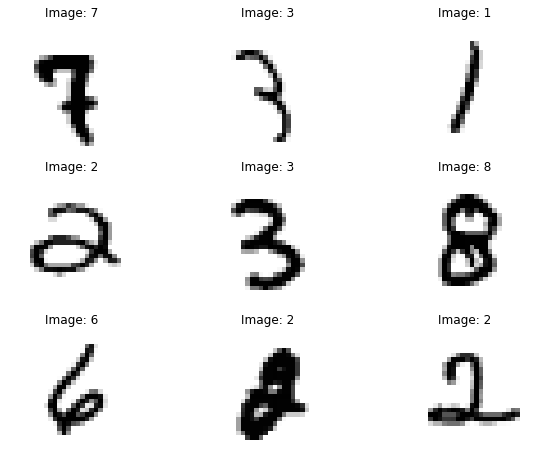

In [22]:
data = iter(train_dataloader)
images, labels = next(data)

plt.figure(figsize=(10,8))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i][0], cmap='gray_r')
    plt.title(f"Label: {labels[i].item()}")
    plt.axis('off')
plt.show()

In [30]:
import os
from PIL import Image
import torch.utils.data as data

class CatDog(data.Dataset):
    def __init__(self, files_dir, transform=None, target_trans=None):
        self.files_dir = files_dir
        self.transform = transform
        self.target_trans = target_trans
        self.list_of_files = os.listdir(files_dir)

    def __len__(self):
        return len(self.list_of_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.files_dir, self.list_of_files[idx])
        img = Image.open(img_path).convert('RGB')
        label = 1 if 'dog' in self.list_of_files[idx] else 0
        if self.transform:
            img = self.transform(img)
        if self.target_trans:
            label = self.target_trans(label)
        return img, label

In [28]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x*2-1)
])

dataset = CatDog('cat_dog_images', transform=transform)
dataloader = data.DataLoader(dataset, batch_size=2, shuffle=True)

for imgs, labels in dataloader:
    print(imgs.shape, labels)

torch.Size([2, 3, 224, 224]) tensor([1, 1])
torch.Size([2, 3, 224, 224]) tensor([0, 1])
torch.Size([2, 3, 224, 224]) tensor([0, 0])


Высокоуровневый API Fast.ai
----

PyTorch лучше всего работает в качестве базовой библиотеки низкого уровня, обеспечивая базовые операции для функциональности более высокого уровня. Библиотека fastai является самой популярной библиотекой для добавления этой высокоуровневой функциональности поверх PyTorch. Он также особенно хорошо подходит для целей этой книги, потому что он уникален тем, что обеспечивает многоуровневую архитектуру программного обеспечения (есть даже [рецензируемая научная статья](https://arxiv.org/abs/2002.04688) об этом многоуровневом API). В этом курсе, по мере того как мы все глубже и глубже погружаемся в основы глубокого обучения, мы также будем все глубже и глубже погружаться в слои fastai. Мы рассматриваем версию 2 библиотеки fastai, которая представляет собой переписанную с нуля версию, предоставляющую множество уникальных функций.

In [1]:
import fastbook
fastbook.setup_book()
from fastbook import *

Загрузка данных в fastai
----

Загрузчики данных-это тонкий класс, который просто хранит любые объекты загрузчика данных, которые вы ему передаете, и делает их доступными в качестве обучаемых и действительных. Хотя это очень простой класс, на самом деле он очень важен: он предоставляет данные для вашей модели. Ключевая функциональность загрузчиков данных обеспечивается только этими четырьмя строками кода (в нем есть некоторые другие незначительные функции, которые мы пока пропустим).

```python
class DataLoaders(GetAttr):
    def __init__(self, *loaders): self.loaders = loaders
    def __getitem__(self, i): return self.loaders[i]
    train,valid = add_props(lambda i,self: self[i]) 
```


In [2]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)/'images'

def is_cat(x): return x[0].isupper()
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=42,
    label_func=is_cat, item_tfms=Resize(224))

Could not do one pass in your dataloader, there is something wrong in it. Please see the stack trace below:


RuntimeError: The MPS backend is supported on MacOS 12.3+.Current OS version can be queried using `sw_vers`

In [ ]:
dls.show_batch(max_n=4, nrows=1)

In [ ]:
img = PILImage.create(image_cat())
img.show()

In [ ]:
uploader = widgets.FileUpload()
uploader = SimpleNamespace(data = ['cat_dog_images/cat-01.jpg'])


In [ ]:
img = PILImage.create(uploader.data[0])
img.show()

Документация
--------------
- [`torch.utils.data` API](https://pytorch.org/docs/stable/data.html)
- [fastai: A Layered API for Deep Learning](https://arxiv.org/abs/2002.04688)

